<a href="https://colab.research.google.com/github/v-artur/Golden_Oreos/blob/main/Modeling1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install some of the dependencies

In [1]:
!pip install fastdtw
!pip install pysptk      
!pip install pyworld

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 4.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pysptk: filename=pysptk-0.2.0-cp37-cp37m-linux_x86_64.whl size=931339 sha256=e9a411a82fb416a71ba68009307f49e3ac69f2853a51c159ac4b301e0dfa4705
  Stored in directory: /root/.cache/pip/wheels/9a/70/a1/757bd6c0017f384831e6260a784f10ff6d7998a805719f9a2d
Successfully built pysptk
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 214 kB 18.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyworld: filename=pyw

Import files from Google drive

In [2]:
#old links, because gdown is not reliable on the long run
#!pip install gdown
#!gdown https://drive.google.com/uc?id=1Uu55cqiSZLCj0fAU7QoXxJSIunsuqHEX
#!gdown https://drive.google.com/u/0/uc?id=1_eeG0d_r-RqazUkr-ZRPNC6L13sHYwIP
#!gdown https://drive.google.com/u/0/uc?id=1Bjf3ncRe8CcWHl3i0HxRo4unRYkz2fog


#the data
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp" -O features.zip && rm -rf /tmp/cookies.txt
#reconstruction module
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1_eeG0d_r-RqazUkr-ZRPNC6L13sHYwIP' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1_eeG0d_r-RqazUkr-ZRPNC6L13sHYwIP" -O reconstructWave.py && rm -rf /tmp/cookies.txt
#Melfiltebank applier
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Bjf3ncRe8CcWHl3i0HxRo4unRYkz2fog' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Bjf3ncRe8CcWHl3i0HxRo4unRYkz2fog" -O MelFilterBank.py && rm -rf /tmp/cookies.txt


#extracting it
import zipfile
zip_ref = zipfile.ZipFile("/content/features.zip", 'r')
zip_ref.extractall("/content/features")
zip_ref.close()

#creating folders for the synthesized audiofiles for the best model and all model types
!mkdir synth_audio    #this one is for the best model, that will be trained and tested on all participants

#these 2 folders will be needed for the evaluation of each model type
!mkdir synth_audio_bn        #bottle neck
!mkdir synth_audio_dnn       #FC-DNN

--2022-11-23 21:53:49--  https://docs.google.com/uc?export=download&confirm=t&id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp
Resolving docs.google.com (docs.google.com)... 172.253.122.138, 172.253.122.101, 172.253.122.100, ...
Connecting to docs.google.com (docs.google.com)|172.253.122.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/je0ceicdv8mkd3dk0u70l3ghuvfehe15/1669240425000/17895932938140350971/*/1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp?e=download&uuid=c40c676c-89c3-4896-95d7-34775faf8006 [following]
--2022-11-23 21:53:49--  https://doc-08-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/je0ceicdv8mkd3dk0u70l3ghuvfehe15/1669240425000/17895932938140350971/*/1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp?e=download&uuid=c40c676c-89c3-4896-95d7-34775faf8006
Resolving doc-08-9o-docs.googleusercontent.com (doc-08-9o-docs.googleusercontent.com)... 172.253.62.1

Necessary models and functions

In [ ]:
import tensorflow as tf
from tensorflow.keras import regularizers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Input 
import numpy as np


#Bottleneck FC-DNN

def create_bottleneck_model(inputsize, outputsize):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(inputsize)))
    model.add(tf.keras.layers.Dense(128, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(64, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(16, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(4, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(16, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(outputsize))
    return model

#Normal FC-DNN

def create_dnn_model(inputsize, outputsize):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(inputsize)))
    model.add(tf.keras.layers.Dense(100, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(100, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(50, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(outputsize))
    return model


In [ ]:
#For audio reconstruction and MCD measure 
#dependencies
import reconstructWave as rW
import MelFilterBank as mel
import numpy as np
import librosa
from scipy.io import wavfile
import pysptk
from scipy.spatial.distance import euclidean
import os
from fastdtw import fastdtw

# functions for MCD calculations 
# (source: https://github.com/ttslr/python-MCD?fbclid=IwAR2OFaz3-8kTfhJXC7F-cmTTHkY-egEzZdSYHsC0agwPw58N2G3hqhfdVNY)


#The following function converts a wav file into a format which can be used to evaluate the MCD score
def readmgc(filename):
    sr, x = wavfile.read(filename)
    assert sr == 16000
    x = x.astype(np.float64)
    frame_length = 1024
    hop_length = 256  
    frames = librosa.util.frame(x, frame_length=frame_length, hop_length=hop_length).astype(np.float64).T
    frames *= pysptk.blackman(frame_length)
    assert frames.shape[1] == frame_length 
    order = 25
    alpha = 0.41
    stage = 5
    gamma = -1.0 / stage

    mgc = pysptk.mgcep(frames, order, alpha, gamma)
    mgc = mgc.reshape(-1, order + 1)
    print("mgc of {} is ok!".format(filename))
    return mgc


# variable for the compute_mcd function 
natural_folder = '/content/features/'


#this function returns the average MCD score for the reconstructed WAV file by a chosen model
def compute_mcd(synth_folder):
  '''
  :param synth_folder: the folder in which the reconstructed WAV files can be found
  '''

  # computing the MCD
  files = os.listdir(synth_folder)
  for subject in files:
    print("Processing -----------{}".format(subject))

    #computational parameters
    _logdb_const = 10.0 / np.log(10.0) * np.sqrt(2.0)
    s = 0.0
    framesTot = 0
    

    # obtaining the mgc features
    subject_ID = subject[0:6]
    filename1 = natural_folder + subject_ID + '_orig_audio.wav'
    mgc1 = readmgc(filename1)
    filename2 = synth_folder + subject_ID + '_predicted.wav'
    mgc2 = readmgc(filename2)
  
    x = mgc1
    y = mgc2
    
    # calculating the mcd
    distance, path = fastdtw(x, y, dist=euclidean)
  
    distance/= (len(x) + len(y))
    pathx = list(map(lambda l: l[0], path))
    pathy = list(map(lambda l: l[1], path))
    x, y = x[pathx], y[pathy]

    frames = x.shape[0]
    framesTot  += frames

    z = x - y
    s += np.sqrt((z * z).sum(-1)).sum()

    MCD_value = _logdb_const * float(s) / float(framesTot)

    print(f"MCD of {subject_ID}: {MCD_value}")


#Reconstructing the WAV file from the predicted mel-log spectrogram (Griffin-Lim method)
def createAudio(spectrogram, audiosr=16000, winLength=0.05, frameshift=0.01):
    mfb = mel.MelFilterBank(int((audiosr*winLength)/2+1), spectrogram.shape[1], audiosr)
    hop = int(spectrogram.shape[0])
    rec_audio = np.array([])
    for_reconstruction = mfb.fromLogMels(spectrogram)
    for w in range(0,spectrogram.shape[0],hop):
        spec = for_reconstruction[w:min(w+hop,for_reconstruction.shape[0]),:]
        rec = rW.reconstructWavFromSpectrogram(spec,spec.shape[0]*spec.shape[1],fftsize=int(audiosr*winLength),overlap=int(winLength/frameshift))
        rec_audio = np.append(rec_audio,rec)
    scaled = np.int16(rec_audio/np.max(np.abs(rec_audio)) * 32767)
    return scaled

In [ ]:
#Setting seed
tf.keras.utils.set_random_seed(1234)

# 1.) One person model

### Optimizing the bottleneck FC-DNN structure for one person



In [ ]:
from scipy.stats import pearsonr
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.io.wavfile as wavfile



data = np.load(r'/content/features/sub-01_feat.npy')
spectrogram = np.load(r'/content/features/sub-01_spec.npy')

#Inital parameters
nfolds = 10
kf = KFold(nfolds,shuffle=False)
pca = PCA()
numComps = 200
val_split = 0.2

#Audio Reconstruction parameters
winLength = 0.05
frameshift = 0.01
audiosr = 16000

#Initialize an empty spectrogram to save the reconstruction to
rec_spec = np.zeros(spectrogram.shape)
#Save the correlation coefficients for each fold
rs = np.zeros((nfolds,spectrogram.shape[1]))
for k,(train, test) in enumerate(kf.split(data)):
          
    #Train, validation and test data
    X_train_temp = data[train,:]
    y_train_temp = spectrogram[train,:]
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=val_split, random_state=0)
    X_test = data[test,:]
    y_test = spectrogram[test,:] # this one might not be needed
    
    #Standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train[:] = scaler.transform(X_train)
    X_val[:] = scaler.transform(X_val)
    X_test[:] = scaler.transform(X_test)

    #Fit PCA to training data
    pca.fit(X_train)
    #Tranform data 
    X_train = np.dot(X_train, pca.components_[:numComps,:].T)
    X_val = np.dot(X_val, pca.components_[:numComps,:].T)
    X_test = np.dot(X_test, pca.components_[:numComps,:].T)

    # Bottleneck model
    early_stopping=EarlyStopping(patience=25, verbose=1, min_delta=1e-5)
    checkpointer=ModelCheckpoint(filepath='weights1.hdf5', save_best_only=True, verbose=1)

    model = create_bottleneck_model(numComps, spectrogram.shape[1])
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    model.fit(X_train, y_train, batch_size=64, 
                     epochs=100, verbose=0, validation_data=(X_val, y_val), shuffle=True,
                     callbacks=[checkpointer, early_stopping])
            
    #predict with the best weights
    model.load_weights('weights1.hdf5')
    rec_spec[test, :] = model.predict(X_test, verbose=0)

    #Evaluate reconstruction of this fold
    for specBin in range(spectrogram.shape[1]):
         r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
         rs[k,specBin] = r


#Show evaluation result
print("")
print('Mean correlation:', np.mean(rs))

#Make and save the synthesized audio
reconstructedWav = createAudio(rec_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_bn/sub-01_predicted.wav'),int(audiosr),reconstructedWav)


Epoch 1: val_loss improved from inf to 5.70766, saving model to weights1.hdf5

Epoch 2: val_loss improved from 5.70766 to 3.30367, saving model to weights1.hdf5

Epoch 3: val_loss improved from 3.30367 to 2.64397, saving model to weights1.hdf5

Epoch 4: val_loss improved from 2.64397 to 2.39077, saving model to weights1.hdf5

Epoch 5: val_loss improved from 2.39077 to 2.21902, saving model to weights1.hdf5

Epoch 6: val_loss did not improve from 2.21902

Epoch 7: val_loss improved from 2.21902 to 1.99770, saving model to weights1.hdf5

Epoch 8: val_loss did not improve from 1.99770

Epoch 9: val_loss improved from 1.99770 to 1.77536, saving model to weights1.hdf5

Epoch 10: val_loss did not improve from 1.77536

Epoch 11: val_loss improved from 1.77536 to 1.66034, saving model to weights1.hdf5

Epoch 12: val_loss did not improve from 1.66034

Epoch 13: val_loss did not improve from 1.66034

Epoch 14: val_loss improved from 1.66034 to 1.63720, saving model to weights1.hdf5

Epoch 15: v

### Optimizing the normal FC-DNN structure for one person


In [ ]:
from scipy.stats import pearsonr
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.io.wavfile as wavfile


data = np.load(r'/content/features/sub-01_feat.npy')
spectrogram = np.load(r'/content/features/sub-01_spec.npy')

#Inital parameters for prediction
nfolds = 10
kf = KFold(nfolds,shuffle=False)
pca = PCA()
numComps = 100
val_split = 0.2

#Audio Reconstruction parameters
winLength = 0.05
frameshift = 0.01
audiosr = 16000


#Initialize an empty spectrogram to save the reconstruction to
rec_spec = np.zeros(spectrogram.shape)
#Save the correlation coefficients for each fold
rs = np.zeros((nfolds,spectrogram.shape[1]))
for k,(train, test) in enumerate(kf.split(data)):
          
    #Train, validation and test data
    X_train_temp = data[train,:]
    y_train_temp = spectrogram[train,:]
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=val_split, random_state=0)
    X_test = data[test,:]
    y_test = spectrogram[test,:] # this one might not be needed
    
    #Standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train[:] = scaler.transform(X_train)
    X_val[:] = scaler.transform(X_val)
    X_test[:] = scaler.transform(X_test)

    #Fit PCA to training data
    pca.fit(X_train)
    #Tranform data 
    X_train = np.dot(X_train, pca.components_[:numComps,:].T)
    X_val = np.dot(X_val, pca.components_[:numComps,:].T)
    X_test = np.dot(X_test, pca.components_[:numComps,:].T)

    # Bottleneck model
    early_stopping=EarlyStopping(patience=25, verbose=1, min_delta=1e-5)
    checkpointer=ModelCheckpoint(filepath='weights1.hdf5', save_best_only=True, verbose=1)

    model = create_dnn_model(numComps, spectrogram.shape[1])
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    model.fit(X_train, y_train, batch_size=64, 
              epochs=100, verbose=0, validation_data=(X_val, y_val), shuffle=True,
              callbacks=[checkpointer, early_stopping])
            
    #predict with the best weights
    model.load_weights('weights1.hdf5')
    rec_spec[test, :] = model.predict(X_test, verbose=0)


    #Evaluate reconstruction of this fold
    for specBin in range(spectrogram.shape[1]):
         r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
         rs[k,specBin] = r


#Show evaluation result
print("")
print('Mean correlation:', np.mean(rs))


#Make and save the synthesized audio
reconstructedWav = createAudio(rec_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_dnn/sub-01_predicted.wav'),int(audiosr),reconstructedWav)


Epoch 1: val_loss improved from inf to 3.52022, saving model to weights1.hdf5

Epoch 2: val_loss improved from 3.52022 to 2.57877, saving model to weights1.hdf5

Epoch 3: val_loss improved from 2.57877 to 2.55904, saving model to weights1.hdf5

Epoch 4: val_loss improved from 2.55904 to 2.14541, saving model to weights1.hdf5

Epoch 5: val_loss did not improve from 2.14541

Epoch 6: val_loss improved from 2.14541 to 2.02208, saving model to weights1.hdf5

Epoch 7: val_loss improved from 2.02208 to 1.82730, saving model to weights1.hdf5

Epoch 8: val_loss did not improve from 1.82730

Epoch 9: val_loss improved from 1.82730 to 1.74393, saving model to weights1.hdf5

Epoch 10: val_loss improved from 1.74393 to 1.59487, saving model to weights1.hdf5

Epoch 11: val_loss improved from 1.59487 to 1.58944, saving model to weights1.hdf5

Epoch 12: val_loss improved from 1.58944 to 1.54860, saving model to weights1.hdf5

Epoch 13: val_loss did not improve from 1.54860

Epoch 14: val_loss improv

# 2.) MCD score evaluation

In [ ]:
import matplotlib.pyplot as plt
import librosa
import pyworld

In [ ]:
#source: https://github.com/SamuelBroughton/Mel-Cepstral-Distortion/blob/master/mel-cepstral-distortion.ipynb
def load_wav(wav_file, sr):
    """
    Load a wav file with librosa.
    :param wav_file: path to wav file
    :param sr: sampling rate
    :return: audio time series numpy array
    """
    wav, _ = librosa.load(wav_file, sr=sr, mono=True)

    return wav

In [ ]:
orig = load_wav('/content/features/sub-01_orig_audio.wav', 16000)
rec_bn = load_wav('/content/synth_audio_bn/sub-01_predicted.wav', 16000)
rec_dnn = load_wav('/content/synth_audio_dnn/sub-01_predicted.wav', 16000)

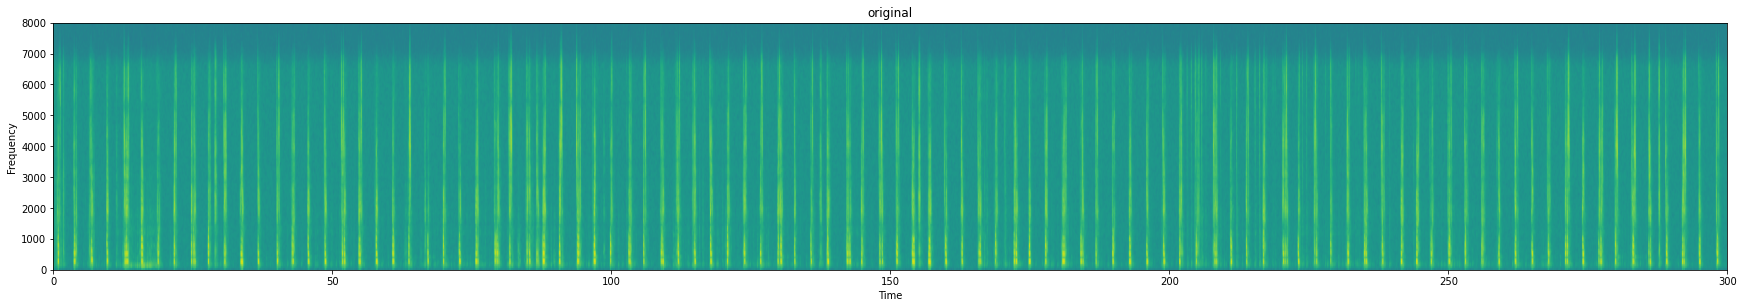

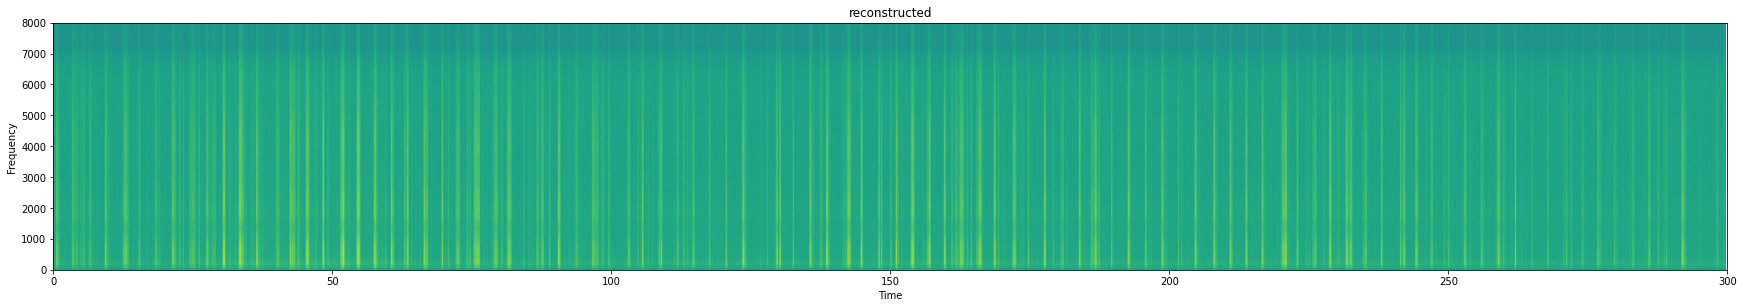

In [ ]:
#from the bottleneck DNN model
#plotting the spectograms of the original sub-o1_orig_audio.wav file and the reconstructed sub-01_predicted.wav file
plt.figure(figsize = (30,10))
plt.subplot(211)
plt.specgram(orig, Fs=16000)
plt.title('original')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

plt.figure(figsize = (30,10))
plt.subplot(212)
plt.specgram(rec_bn, Fs=16000)
plt.title('reconstructed')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

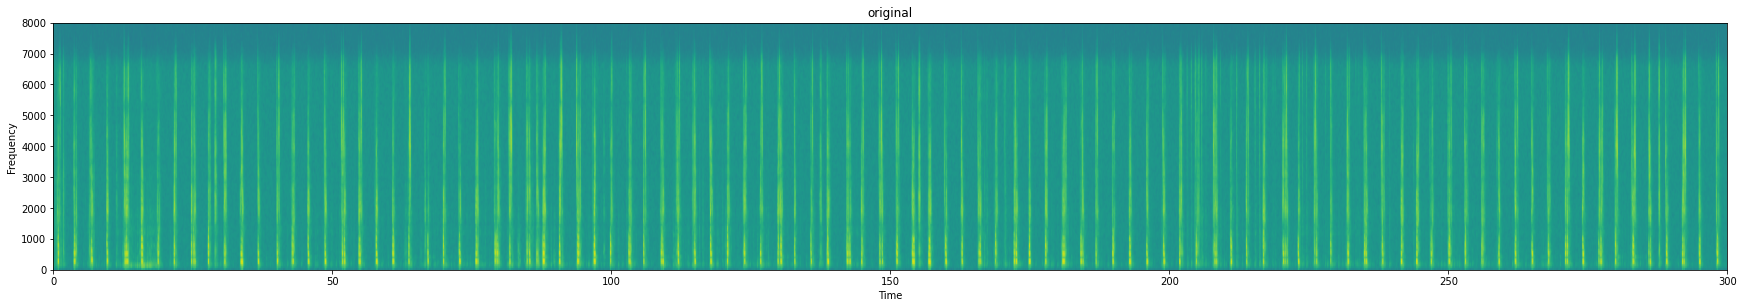

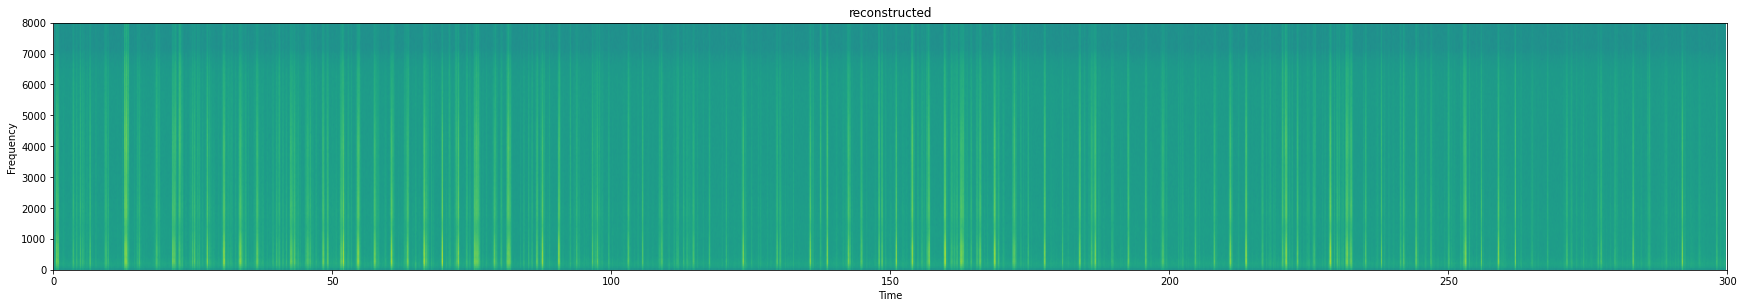

In [ ]:
#from the normal DNN model
#plotting the spectograms of the original sub-o1_orig_audio.wav file and the reconstructed sub-01_predicted.wav file
plt.figure(figsize = (30,10))
plt.subplot(211)
plt.specgram(orig, Fs=16000)
plt.title('original')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

plt.figure(figsize = (30,10))
plt.subplot(212)
plt.specgram(rec_dnn, Fs=16000)
plt.title('reconstructed')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

In [ ]:
# From the bottleneck FC-DNN model
compute_mcd('/content/synth_audio_bn/')

Processing -----------sub-01_predicted.wav
mgc of /content/features/sub-01_orig_audio.wav is ok!
mgc of /content/synth_audio_bn/sub-01_predicted.wav is ok!
MCD of sub-01: 7.7355045232373305


In [ ]:
# From the normal FC-DNN model
compute_mcd('/content/synth_audio_dnn/')

Processing -----------sub-01_predicted.wav
mgc of /content/features/sub-01_orig_audio.wav is ok!
mgc of /content/synth_audio_dnn/sub-01_predicted.wav is ok!
MCD of sub-01: 3.758575208275109


# 3.) Trying out the best configuration for every subject

In [ ]:
# from scipy.stats import pearsonr
# from sklearn.model_selection import KFold, train_test_split
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# import scipy.io.wavfile as wavfile
# ##### MODELING ########

# # So far, the best performance came from the normal DNN model

# model = True

# scores= []

# if model == True:
#     feat_path = r'/content/features'
#     result_path = r'/content/synth_audio'
#     pts = ['sub-%02d'%i for i in range(1,11)]

#     winLength = 0.05
#     frameshift = 0.01
#     audiosr = 16000

#     nfolds = 10
#     kf = KFold(nfolds,shuffle=False)
#     pca = PCA()
#     numComps = 50
    

#     for pNr, pt in enumerate(pts):
        
        
#         #Load the data
#         #Dimensions of these data vary depending on the subject
#         spectrogram = np.load(os.path.join(feat_path,f'{pt}_spec.npy'))  
#         data = np.load(os.path.join(feat_path,f'{pt}_feat.npy'))

        
#         #Initialize an empty spectrogram to save the reconstruction to
#         rec_spec = np.zeros(spectrogram.shape)
#         #Save the correlation coefficients for each fold
#         rs = np.zeros((nfolds,spectrogram.shape[1]))
#         for k,(train, test) in enumerate(kf.split(data)):
          
#             #Train, validation and test data
#             X_train_temp = data[train,:]
#             y_train_temp = spectrogram[train,:]
#             X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=val_split, random_state=0)
#             X_test = data[test,:]
#             y_test = spectrogram[test,:] # this one might not be needed
            
#             #Standardization
#             scaler = StandardScaler()
#             scaler.fit(X_train)
#             X_train[:] = scaler.transform(X_train)
#             X_val[:] = scaler.transform(X_val)
#             X_test[:] = scaler.transform(X_test)


#             #Fit PCA to training data
#             pca.fit(X_train)
#             #Tranform data 
#             X_train = np.dot(X_train, pca.components_[:numComps,:].T)
#             X_val = np.dot(X_val, pca.components_[:numComps,:].T)
#             X_test = np.dot(X_test, pca.components_[:numComps,:].T)

#             # normal DNN model
#             early_stopping=EarlyStopping(patience=25, verbose=0, min_delta=1e-5)
#             checkpointer=ModelCheckpoint(filepath='weights1.hdf5', save_best_only=True, verbose=0)

#             model = create_simple_model(numComps, spectrogram.shape[1])
#             model.compile(loss='mse', optimizer='adam', metrics=['mse'])
#             model.fit(X_train, y_train, batch_size=64, 
#                       epochs=100, verbose=0, validation_data=(X_val, y_val), shuffle=True,
#                       callbacks=[checkpointer, early_stopping])
                    
#             #predict with the best weights
#             model.load_weights('weights1.hdf5')
#             rec_spec[test, :] = model.predict(X_test, verbose=0)

#             #Evaluate reconstruction of this fold
#             for specBin in range(spectrogram.shape[1]):
#                 if np.any(np.isnan(rec_spec)):
#                     print('%s has %d broken samples in reconstruction' % (pt, np.sum(np.isnan(rec_spec))))
#                 r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
#                 rs[k,specBin] = r

#         #Show evaluation result
#         print('%s has mean correlation of %f' % (pt, np.mean(rs)))
#         scores.append(np.mean(rs))


#         #Make and save the synthesized audio
#         reconstructedWav = createAudio(rec_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
#         wavfile.write(os.path.join('/content/synth_audio/',f'{pt}_predicted.wav'),int(audiosr),reconstructedWav)
        
# # MCD score for the subjects
# compute_mcd('/content/synth_audio/')